# APPLE Stock Price Forecasting

### Import libraries

In [80]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Python set up
import warnings
import itertools
# from pandas import datetime
from pandas import read_csv
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot') 
import seaborn as sns  
sns.set(style="whitegrid")

#### Loading the dataset from yfinance

In [42]:

ticker = "AAPL"
df = yf.download(ticker, start="2015-01-01", end="2024-12-31", progress=False)

df.head(10)  ## loading top 10 observation from the datase

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.237545,24.705314,23.798595,24.694229,212818400
2015-01-05,23.554741,24.086801,23.368521,24.006992,257142000
2015-01-06,23.556961,23.816340,23.195602,23.619034,263188400
2015-01-07,23.887278,23.987038,23.654501,23.765347,160423600
2015-01-08,24.805075,24.862715,24.097878,24.215376,237458000
2015-01-09,24.831678,25.106576,24.432633,24.977994,214798000
2015-01-12,24.219818,24.969135,24.120058,24.962485,198603200
2015-01-13,24.434855,25.006819,24.144439,24.703101,268367600


#### Flatten the MultiIndex columns

In [43]:
df.columns = ['_'.join(col).strip() for col in df.columns.values]
# Check the new columns
print(df.columns)

Index(['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL'], dtype='str')


## Apple Stock Price Dataset (2015 - 2024)

This dataset contains historical stock prices for **Apple Inc. (AAPL)**. The data is structured as a **pandas DataFrame with a MultiIndex for columns**, where the first level represents the **price type** and the second level represents the **ticker**. The **index** represents the **date** of each trading day.

---

### **Columns**

| Price Type | Ticker |
|------------|--------|
| Close      | AAPL   |
| High       | AAPL   |
| Low        | AAPL   |
| Open       | AAPL   |
| Volume     | AAPL   |

- **Open**: Stock price at the start of the trading day  
- **High**: Highest stock price during the day  
- **Low**: Lowest stock price during the day  
- **Close**: Stock price at the end of the trading day  
- **Volume**: Number of shares traded during the day  

---
> The dataset can be used for **time series analysis, forecasting, or visualization** of Apple’s stock performance over time.


#### See the total no. of observations and Columns

In [44]:
rows, columns = df.shape
print(f"This dataset contains {rows} Observations overtime and {columns} columns.")

This dataset contains 2515 Observations overtime and 5 columns.


### ✅ Time Series Data Validation Checklist

- [x] Check for missing dates and timestamp gaps
- [x] Verify absence of duplicate timestamps
- [ ] Descriptive Statistics- mean, mediun mode & outlier
- [x] Date column converted to `datetime` format
- [x] Validate numerical data types for all features  
- [x] Time index sorted in chronological order
- [ ] Time Series Decomposition
- [x] Analyze stationarity of the time series  
- [x] Identify trends and volatility patterns  
- [x] Examine autocorrelation and partial autocorrelation  
- [x] Apply time-aware train–test split (no shuffling)



#### Checking for missing value in dataset & Validate numerical data types for all features

In [45]:
### Funciton to display data informaiton

def Columns_Info(df):
    """
    Display a detailed table showing:
    - Number of unique values per column
    - Number of null values
    - Data type
    - Total rows, total columns, count of each data type
    """
    # Column-wise info
    unique_counts = {
        "Column": df.columns,
        "Unique Values": [df[col].nunique() for col in df.columns],
        "Null Values": [df[col].isna().sum() for col in df.columns],
        "Data Type": [df[col].dtype for col in df.columns]
    }
    result_df = pd.DataFrame(unique_counts)
    
    # Overall info
    total_rows = df.shape[0]
    total_cols = df.shape[1]
    dtype_counts = df.dtypes.value_counts().to_dict()
    
    # Display
    print(f"Total Rows: {total_rows}")
    print(f"Total Columns: {total_cols}")
    print("Column types count:", dtype_counts)
    print("-"*50)
    display(result_df)

In [46]:
Columns_Info(df)

Total Rows: 2515
Total Columns: 5
Column types count: {dtype('float64'): 4, dtype('int64'): 1}
--------------------------------------------------


,Column,Unique Values,Null Values,Data Type
0,Close_AAPL,2481,0,float64
1,High_AAPL,2515,0,float64
2,Low_AAPL,2515,0,float64
3,Open_AAPL,2515,0,float64
4,Volume_AAPL,2508,0,int64


### 🔍 Key Inferences

- ✅ **No missing values** across all columns, indicating a **clean and reliable dataset**.
- 📈 **Price columns (`Open`, `High`, `Low`, `Close`)** are stored as floating-point numbers, which is ideal for statistical analysis and modeling.
- 📉 **Volume** is stored as an integer, representing the number of shares traded per day.
- 🔁 The `Close` and `Volume` columns have slightly fewer unique values than total rows, suggesting **repeated values on some trading days**, which is common in financial markets.
- 🕒 With over **2,500 records**, the dataset provides a **long historical range**, making it well-suited for:
  - Time series analysis
  - Trend detection
  - Volatility analysis
  - Stock price forecasting models (ARIMA, LSTM, etc.)


#### Verify absence of duplicate timestamps

In [47]:
duplicate_check = df.index.duplicated().sum()

if duplicate_check == 0:
    print("✅ No duplicate timestamps found in the dataset.")
else:
    print(f"⚠️ Dataset contains {duplicate_check} duplicate timestamps.")


✅ No duplicate timestamps found in the dataset.


#### Date column converted to datetime format

In [48]:
df.index.name

'Date'

Using the Date as a `DatetimeIndex` ensures chronological ordering and enables time-aware operations like resampling, rolling windows, and date-based slicing.  
It also improves modeling accuracy and prevents data leakage in time series analysis.


In [49]:
if isinstance(df.index, pd.DatetimeIndex):
    print("✅ Date index is successfully converted to pandas.DatetimeIndex.")
else:
    print("❌ Date index is not in datetime format.")

✅ Date index is successfully converted to pandas.DatetimeIndex.


 #### Descriptive Statistics- mean, mediun mode & outlier

In [50]:
df.describe()

,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
count,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03
mean,93.797132,94.707869,92.783453,93.709473,1.171162e+08
std,65.380823,65.973200,64.693209,65.298504,6.839222e+07
min,20.604076,20.907414,20.405654,20.526533,2.323470e+07
25%,35.203344,35.606984,34.844189,35.234246,7.108655e+07
50%,64.373749,64.723198,63.565060,64.132057,1.003845e+08
75%,150.219719,151.947363,148.203861,150.002039,1.426222e+08
max,257.853790,258.928945,256.470064,257.027541,6.488252e+08


#### Time index sorted in chronological order

In [51]:
# Check if Date index is sorted
if df.index.is_monotonic_increasing:
    print("✅ The Date index is sorted in chronological order.")
    print(f"First date: {df.index.min()} | Last date: {df.index.max()}")
else:
    print("⚠️ The Date index is NOT sorted! Sorting now...")
    df = df.sort_index()
    print("✅ Date index sorted successfully.")
    print(f"First date: {df.index.min()} | Last date: {df.index.max()}")


✅ The Date index is sorted in chronological order.
First date: 2015-01-02 00:00:00 | Last date: 2024-12-30 00:00:00


## Time Series Decomposition

**Decomposition** is the process of breaking a time series into its underlying components to better understand its behavior. It helps identify patterns, trends, and randomness in the data.

### Components of a Time Series

1. **Trend (T)**
   - Long-term movement in the data
   - Shows general upward or downward direction
   - Example: Apple stock prices generally increasing over years

2. **Seasonality (S)**
   - Regular repeating patterns in a fixed period
   - Example: Increased sales in December each year
   - Pattern repeats daily, weekly, monthly, or yearly

3. **Residual / Noise (R)**
   - Remaining part of the series after removing trend and seasonality
   - Represents randomness or irregular fluctuations
   - Example: One-day market shock or sudden price spike

4. **Cyclic (C)** (optional)
   - Long-term oscillations not strictly seasonal
   - Example: Economic cycles, business cycles

### Mathematical Representation

- **Additive model** (constant variation over time):  
\[
Y_t = T_t + S_t + R_t
\]

- **Multiplicative model** (variation grows with trend):  
\[
Y_t = T_t \times S_t \times R_t
\]

### Purpose of Decomposition

- Identify the **trend** → understand long-term direction  
- Identify **seasonal patterns** → detect repeating cycles  
- Separate **residuals/noise** → detect anomalies or randomness  
- Aid **forecasting models** (ARIMA, SARIMA, etc.) by removing trend and seasonality

### Visualization

Decomposition allows you to visualize each component:

- Original series  
- Trend  
- Seasonality  
- Residuals  

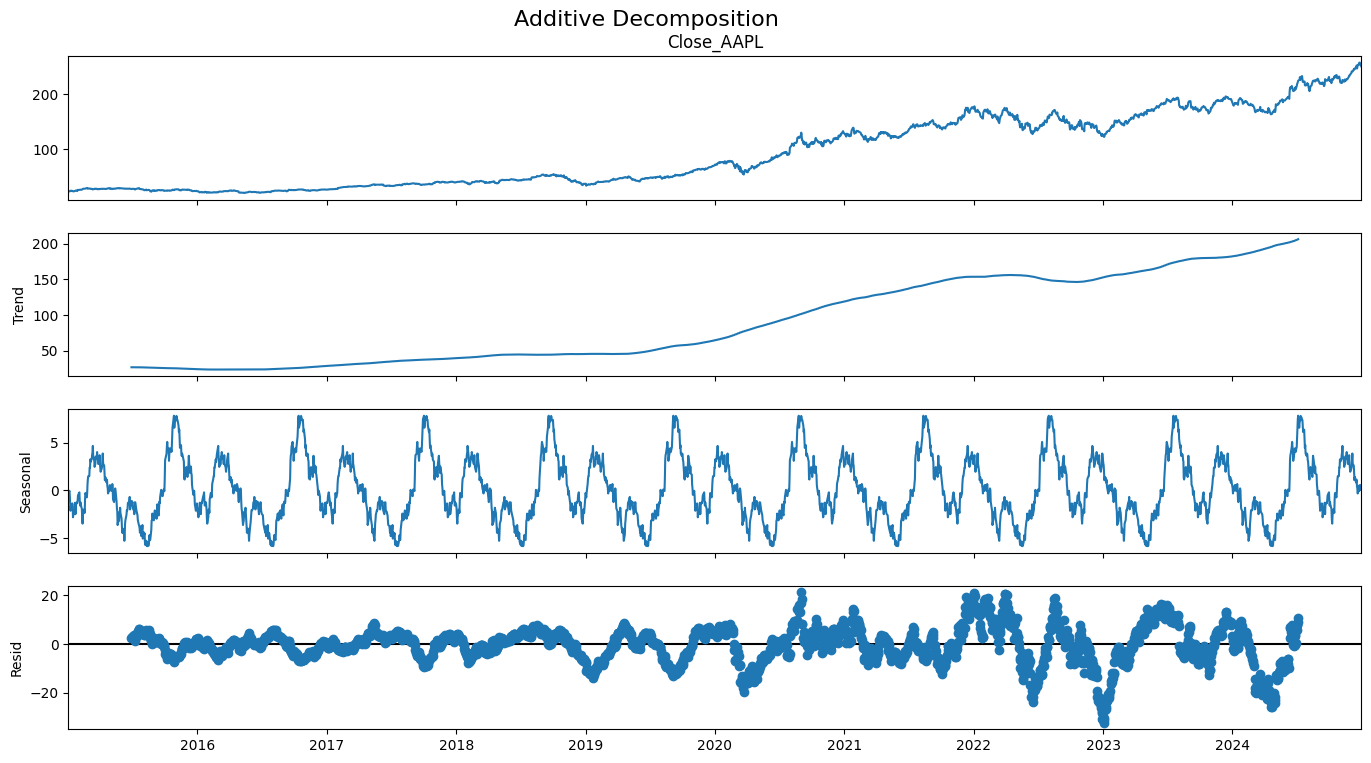

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure datetime index
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Set business day frequency and fill missing values
df = df.asfreq('B')
df['Close_AAPL'] = df['Close_AAPL'].interpolate(method='time')

# Additive decomposition
decomposition_add = seasonal_decompose(df['Close_AAPL'], model='additive', period=252)

# Plot
fig_add = decomposition_add.plot()
fig_add.set_size_inches(15, 8)
plt.suptitle('Additive Decomposition', fontsize=16)
plt.show()


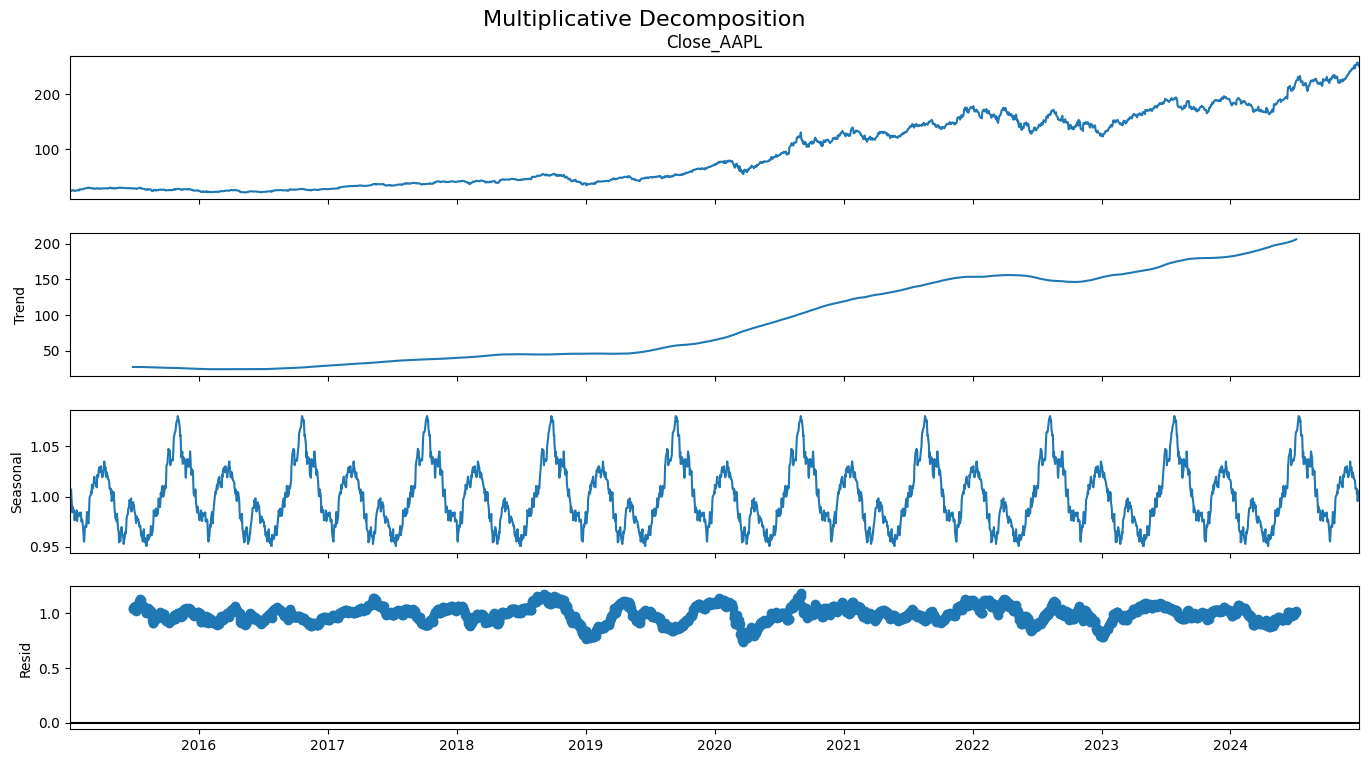

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure datetime index
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Set business day frequency and fill missing values
df = df.asfreq('B')
df['Close_AAPL'] = df['Close_AAPL'].interpolate(method='time')

# Multiplicative decomposition
decomposition_mul = seasonal_decompose(df['Close_AAPL'], model='multiplicative', period=252)

# Plot
fig_mul = decomposition_mul.plot()
fig_mul.set_size_inches(15, 8)
plt.suptitle('Multiplicative Decomposition', fontsize=16)
plt.show()


### Analyze stationarity of the time series

 #### 1. Visual inspection

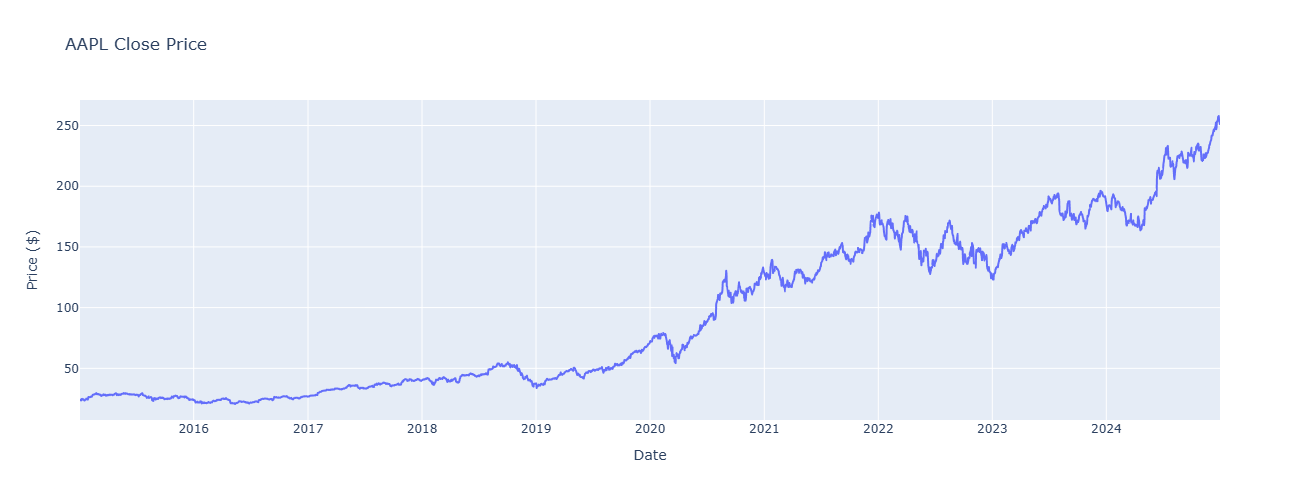

In [52]:
import plotly.express as px

fig = px.line(df, x=df.index, y='Close_AAPL', title='AAPL Close Price')
fig.update_layout(width=900, height=500, xaxis_title='Date', yaxis_title='Price ($)')
fig.show()

#### 2. Rolling statistics

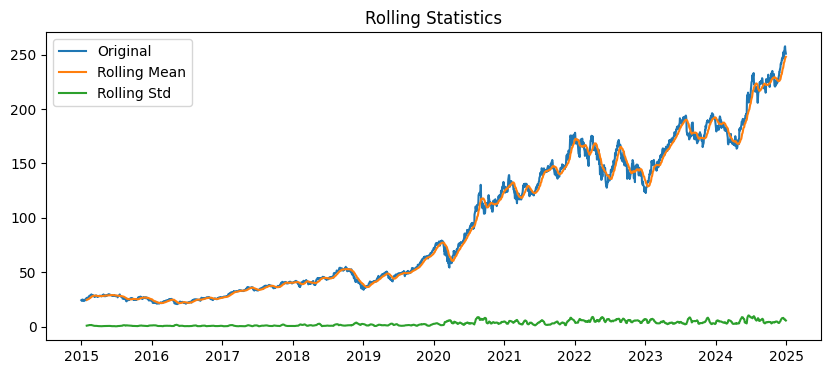

In [53]:
window = 20

rolling_mean = df['Close_AAPL'].rolling(window).mean()
rolling_std = df['Close_AAPL'].rolling(window).std()

plt.figure(figsize=(10,4))
plt.plot(df['Close_AAPL'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.title('Rolling Statistics')
plt.show()

The rolling mean is not flat, indicating a changing mean over time.  
The rolling standard deviation varies, indicating non-constant variance.  

Since both mean and variance change with time, the time series is **non-stationary**.


#### 3.Augmented Dickey-Fuller (ADF) Test 

In [54]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close_AAPL'].dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: 0.8448213764734773
p-value: 0.9923262785274692


#### Augmented Dickey-Fuller (ADF) Test – Hypothesis Interpretation

**Null Hypothesis (H₀):**  
The time series is non-stationary (has a unit root).

**Alternative Hypothesis (H₁):**  
The time series is stationary.

**Test Results:**  
- ADF Statistic = 0.8448  
- p-value = 0.9923  

**Decision:**  
Since the p-value is much greater than 0.05, we fail to reject the null hypothesis.

**Conclusion:**  
There is strong evidence that the time series is **non-stationary**.


#### 4. KPSS Test

In [35]:
from statsmodels.tsa.stattools import kpss

kpss_stat, p_value, _, _ = kpss(df['Close_AAPL'].dropna(), regression='c')

print('KPSS Statistic:', kpss_stat)
print('p-value:', p_value)

KPSS Statistic: 7.721471235923684
p-value: 0.01


C:\Users\Kartik\AppData\Local\Temp\ipykernel_8720\956769693.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




## KPSS Test Result – Explanation and Interpretation

### Why the Warning Appears
The KPSS test uses a predefined lookup table of critical values to compute p-values.  
In this case, the KPSS test statistic is **7.72**, which is larger than the maximum value covered in the lookup table.  
As a result, the test cannot compute the exact p-value and returns the smallest available value (**0.01**) along with a warning.

This warning means that the **actual p-value is smaller than 0.01**, indicating extremely strong evidence against stationarity.

---

### KPSS Hypotheses
- **Null Hypothesis (H₀):** The time series is stationary.
- **Alternative Hypothesis (H₁):** The time series is non-stationary.

---

### Test Results
- **KPSS Statistic:** 7.7215  
- **p-value:** ≤ 0.01  

---

### Decision
Since the p-value is less than 0.05, we reject the null hypothesis.

---

### Conclusion
There is **strong evidence that the time series is non-stationary**.  
The warning does not indicate an error in the code; rather, it confirms that the series deviates significantly from stationarity.

---

### Combined ADF and KPSS Interpretation
- **ADF Test:** Fails to reject non-stationarity  
- **KPSS Test:** Rejects stationarity  

All tests consistently indicate that the time series is **non-stationary**.


#### Trend and Volatility Analysis

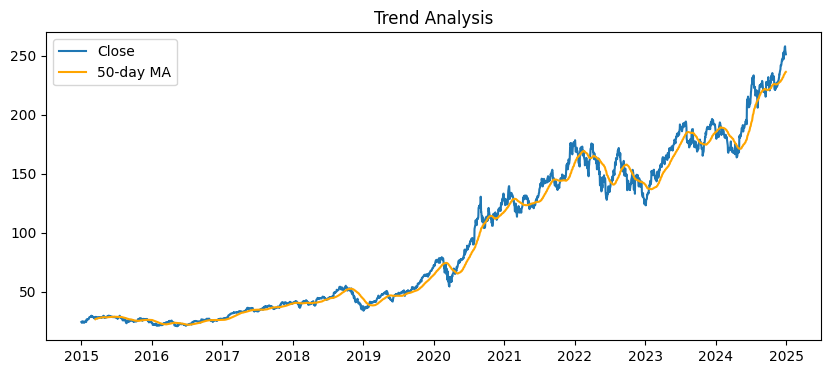

In [37]:
df['MA50'] = df['Close_AAPL'].rolling(window=50).mean()
plt.figure(figsize=(10,4))
plt.plot(df['Close_AAPL'], label='Close')
plt.plot(df['MA50'], label='50-day MA', color='orange')
plt.title('Trend Analysis')
plt.legend()
plt.show()


## Volatility Analysis Using Rolling Standard Deviation

### What is Volatility?

Volatility measures how much the stock price fluctuates over time. It is often used as a proxy for **risk** — higher volatility means the stock price changes rapidly and unpredictably, while lower volatility indicates more stable prices.

---

### How is Volatility Measured Here?

In this analysis, volatility is calculated using the **rolling standard deviation** of the closing prices over a 20-day window. This means we look at the standard deviation of prices in each 20-day segment as it moves through time, providing a dynamic measure of how much the stock price varies in recent periods.

---

### Interpretation of the Volatility Plot

- When the volatility line **rises**, it indicates periods where the stock price experiences larger swings or fluctuations.
- When the volatility line **falls**, it shows times of relative price stability.
- The plot often reveals **volatility clustering**, where calm periods are followed by bursts of higher volatility, which is typical behavior in financial markets.
- Understanding these patterns helps identify periods of high uncertainty or risk.

---

### Why is Volatility Important?

- Volatility quantifies the **risk and uncertainty** associated with the stock price.
- It is crucial for traders, investors, and risk managers to gauge how much price movement to expect.
- Models that forecast stock prices often incorporate volatility to improve prediction accuracy.
- Volatility insights help in portfolio management, option pricing, and setting stop-loss limits.

---

### Summary

- **Rolling standard deviation** provides a moving estimate of volatility, reflecting how variability changes over time.
- Periods of **high volatility** mean increased price fluctuations and higher investment risk.
- Periods of **low volatility** suggest more stable price behavior and lower risk.
- Monitoring volatility alongside price trends offers a fuller picture of market dynamics and potential risks.


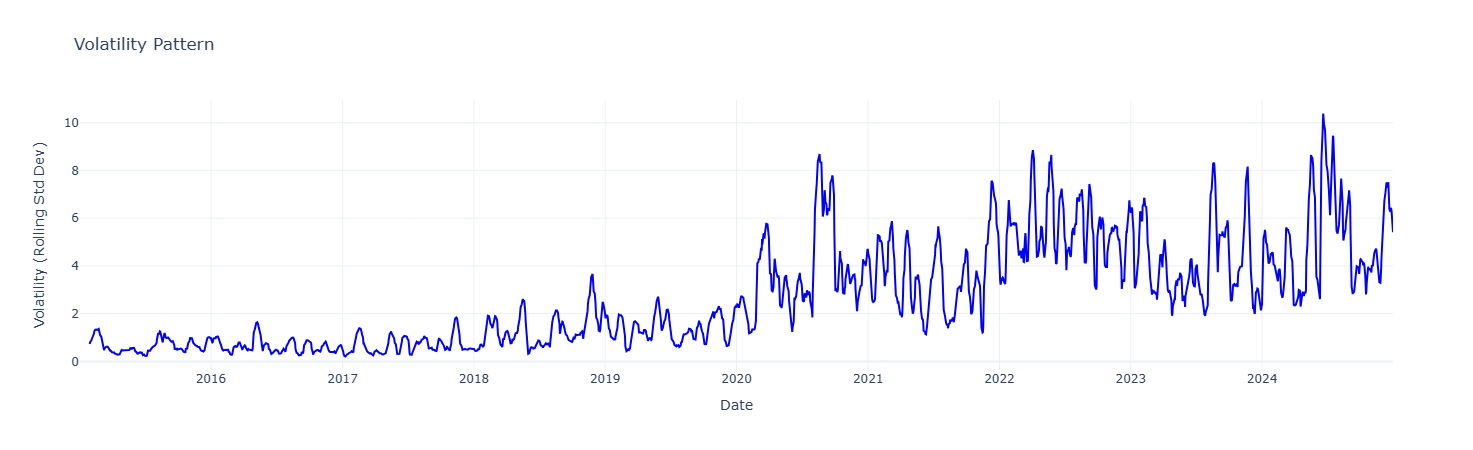

In [65]:
import plotly.graph_objects as go

# Calculate 20-day rolling standard deviation (volatility)
df['Volatility'] = df['Close_AAPL'].rolling(window=20).std()

# Create Plotly figure
fig = go.Figure()

# Add volatility line
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Volatility'],
    mode='lines',
    name='20-day Rolling Std',
    line=dict(color='blue')
))

# Update layout for better visuals
fig.update_layout(
    title='Volatility Pattern',
    xaxis_title='Date',
    yaxis_title='Volatility (Rolling Std Dev)',
    template='plotly_white',
    width=900,
    height=450
)

# Show plot
fig.show()



####  Autocorrelation Analysis

<Figure size 1000x400 with 0 Axes>

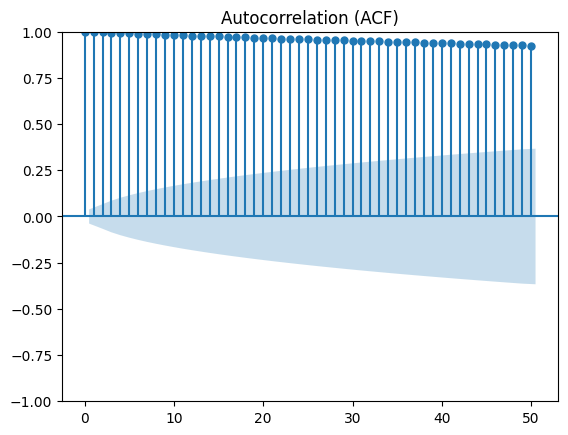

<Figure size 1000x400 with 0 Axes>

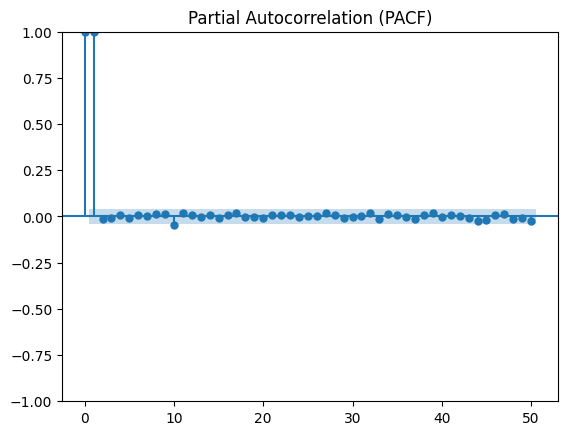

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10,4))
plot_acf(df['Close_AAPL'].dropna(), lags=50)
plt.title('Autocorrelation (ACF)')
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(df['Close_AAPL'].dropna(), lags=50)
plt.title('Partial Autocorrelation (PACF)')
plt.show()  

## Inference

### What is a Lag?
A **lag** is the number of time steps you look back in a time series.  
- **Lag 1** means comparing today’s value with yesterday’s value.  
- **Lag 2** means comparing today’s value with the value from two days ago, and so on.

---

### Interpretation of Your ACF and PACF Plots

#### Autocorrelation Function (ACF)
- Shows the correlation between the time series and its past values at different lags.  
- In your plot, the ACF values **start near 1 and decay slowly**, remaining significantly positive for many lags.  
- This suggests **strong persistence and possible non-stationarity** in the series (the values depend heavily on past values over a long time).  
- Slowly decaying ACF is typical of a series with a trend or long memory.

#### Partial Autocorrelation Function (PACF)
- Shows the correlation between the series and a specific lag after removing the influence of shorter lags.  
- Your PACF plot shows a **sharp cutoff after lag 1 or 2**, with values near zero afterward.  
- This indicates that only the first one or two lags have a direct influence on the current value, suggesting an **autoregressive (AR) process of order 1 or 2**.

---

### Role of ACF and PACF in Modeling

| Plot | Purpose | Interpretation in Your Case |
|-------|---------|-----------------------------|
| **ACF** | Measures overall correlation with past values; helps identify Moving Average (MA) terms | Slow decay → Non-stationarity or presence of trend |
| **PACF** | Measures direct correlation at specific lags; helps identify Autoregressive (AR) terms | Sharp cutoff after lag 1 or 2 → AR(1) or AR(2) process |

---

### What Next?

- The slow decay in ACF suggests the series is **non-stationary** and may need differencing before modeling.
- The PACF suggests including **1 or 2 autoregressive terms (AR)** in your model.
- Use this insight to select parameters `(p, d, q)` in ARIMA models:
  - `p` (AR order) from PACF cutoff  
  - `d` (differencing) from stationarity tests  
  - `q` (MA order) from ACF cutoff (if any sharp cutoff appears)



## Make the series Stationary

ADF Statistic: -16.234551376457084
p-value: 3.781577291192009e-29
KPSS Statistic: 0.26678006332569304
p-value: 0.1


C:\Users\Kartik\AppData\Local\Temp\ipykernel_8720\237655996.py:29: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




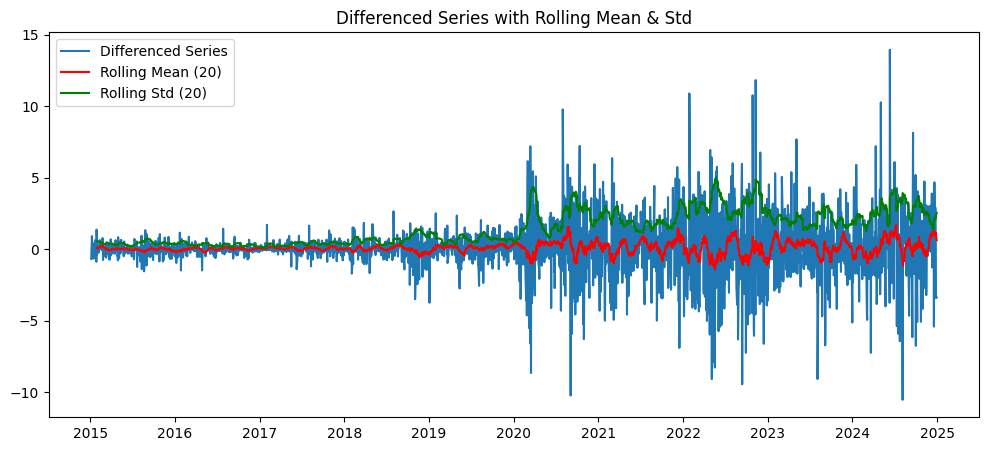

<Figure size 1000x400 with 0 Axes>

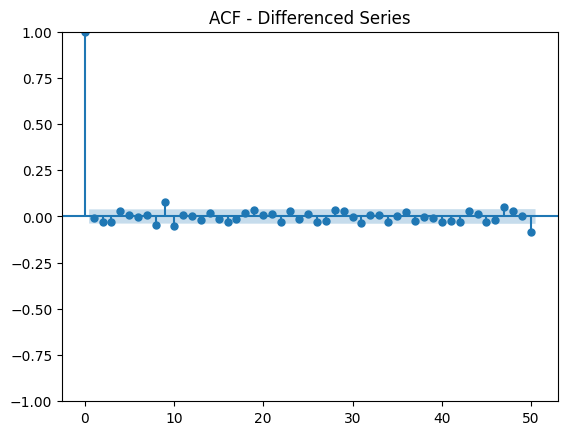

<Figure size 1000x400 with 0 Axes>

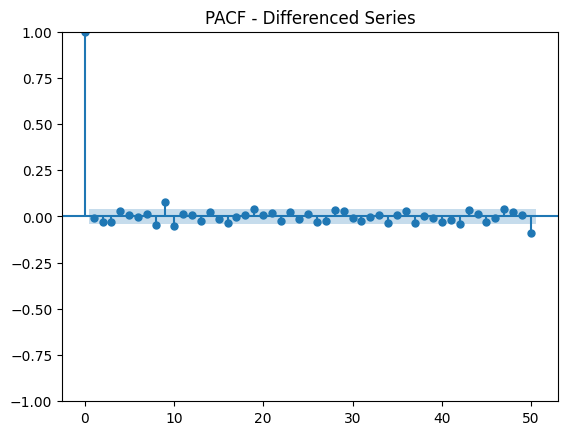

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure datetime index and sort
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# Fill missing values and set business day frequency
df = df.asfreq('B')
df['Close_AAPL'] = df['Close_AAPL'].interpolate(method='time')

# ---------------------------
# 1. Differencing to make series stationary
# ---------------------------
df['Close_diff'] = df['Close_AAPL'].diff()  # first-order difference
df['Close_diff'] = df['Close_diff'].dropna()  # remove NaN after differencing

# ---------------------------
# 2. Re-check stationarity
# ---------------------------
# ADF Test
adf_result = adfuller(df['Close_diff'].dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

# KPSS Test
kpss_result = kpss(df['Close_diff'].dropna(), regression='c')
print("KPSS Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])

# ---------------------------
# 3. Plot rolling mean and standard deviation
# ---------------------------
rolling_mean = df['Close_diff'].rolling(window=20).mean()
rolling_std = df['Close_diff'].rolling(window=20).std()

plt.figure(figsize=(12,5))
plt.plot(df['Close_diff'], label='Differenced Series')
plt.plot(rolling_mean, color='red', label='Rolling Mean (20)')
plt.plot(rolling_std, color='green', label='Rolling Std (20)')
plt.title('Differenced Series with Rolling Mean & Std')
plt.legend()
plt.show()

# ---------------------------
# 4. Re-examine ACF and PACF
# ---------------------------
plt.figure(figsize=(10,4))
plot_acf(df['Close_diff'].dropna(), lags=50)
plt.title('ACF - Differenced Series')
plt.show()

plt.figure(figsize=(10,4))
plot_pacf(df['Close_diff'].dropna(), lags=50)
plt.title('PACF - Differenced Series')
plt.show()


## Stationarity Check After Differencing

After applying **first-order differencing** to the `Close_AAPL` series, we re-evaluated stationarity using **ADF** and **KPSS** tests.

### ADF Test
- **ADF Statistic:** -16.23  
- **p-value:** 3.78e-29  

**Interpretation:**  
- Null Hypothesis (H0): The series is **non-stationary**  
- Since the **p-value << 0.05**, we **reject H0**.  
- ✅ This indicates the series is **stationary**.

### KPSS Test
- **KPSS Statistic:** 0.267  
- **p-value:** 0.1  

**Interpretation:**  
- Null Hypothesis (H0): The series is **stationary**  
- Since the **p-value > 0.05**, we **fail to reject H0**.  
- ✅ Confirms the series is **stationary**.

---

### Conclusion
- Both ADF and KPSS tests consistently indicate that the **differenced `Close_AAPL` series is now stationary**.  
- This means the series is ready for **ARIMA modeling or other time series forecasting methods**.


### Fitting an model

#### ARIMA Model Overview and Parameter Selection

The `statsmodels` library allows us to fit ARIMA models for time series forecasting. An ARIMA model is specified by three parameters `(p, d, q)`:

- **p (AR order)**: Number of autoregressive terms (lags of the series).  
- **d (Difference order)**: Number of differencing steps to achieve stationarity.  
- **q (MA order)**: Number of moving average terms (lags of forecast errors).

---

### How to Choose `(p, d, q)` for Our Series

- **d = 1**: Based on stationarity tests and differencing, we set `d = 1`.
- **p (AR order)**: Determined from the **PACF** plot of the differenced series. A sharp cutoff in PACF at lag `p` suggests the AR order.
- **q (MA order)**: Determined from the **ACF** plot of the differenced series. A sharp cutoff in ACF at lag `q` suggests the MA order.

---

### Example

- An ARIMA(5,1,0) model uses 5 AR terms, one differencing step, and no MA terms.

Based on our ACF and PACF analysis for this dataset, the recommended model is:

- **ARIMA(0,1,0)**  
  - No significant AR or MA terms observed after differencing.  
  - The differenced series behaves like white noise, so simplest model suffices.

---

### Fitting ARIMA in Python

- Use `ARIMA()` from `statsmodels.tsa.arima.model` with chosen `(p, d, q)`.  
- Fit the model on training data with `.fit()`.  
- Predict future values with `.predict()`.  
- To suppress verbose output during fitting, use `disp=0`.

---

### Summary Table

| Parameter | Meaning                     | Example Value (Our Case) |
|-----------|-----------------------------|-------------------------|
| p         | Number of AR terms          | 0                       |
| d         | Differencing order          | 1                       |
| q         | Number of MA terms          | 0                       |

---




In [70]:
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA(0,1,0) model
model = ARIMA(df['Close_AAPL'], order=(0,1,0))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Close_AAPL   No. Observations:                 2607
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -5329.545
Date:                Fri, 30 Jan 2026   AIC                          10661.090
Time:                        14:34:33   BIC                          10666.955
Sample:                    01-02-2015   HQIC                         10663.215
                         - 12-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.4985      0.047     74.852      0.000       3.407       3.590
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):              4747.05
Prob(Q):                              0.65   Pr

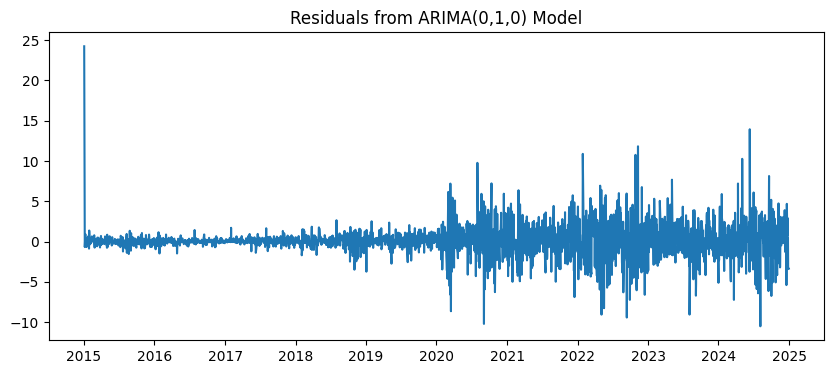

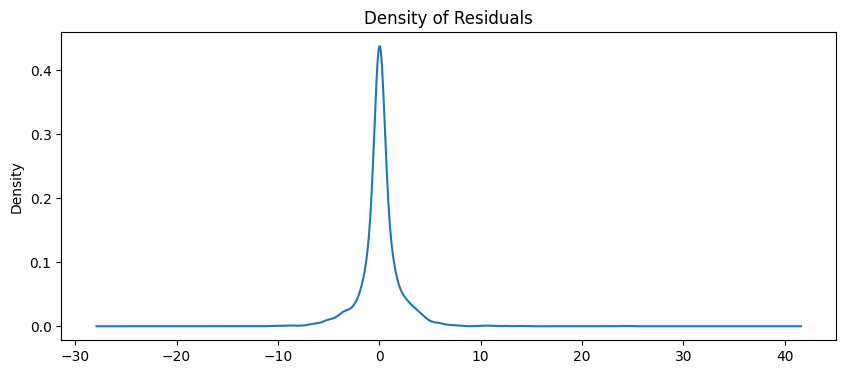

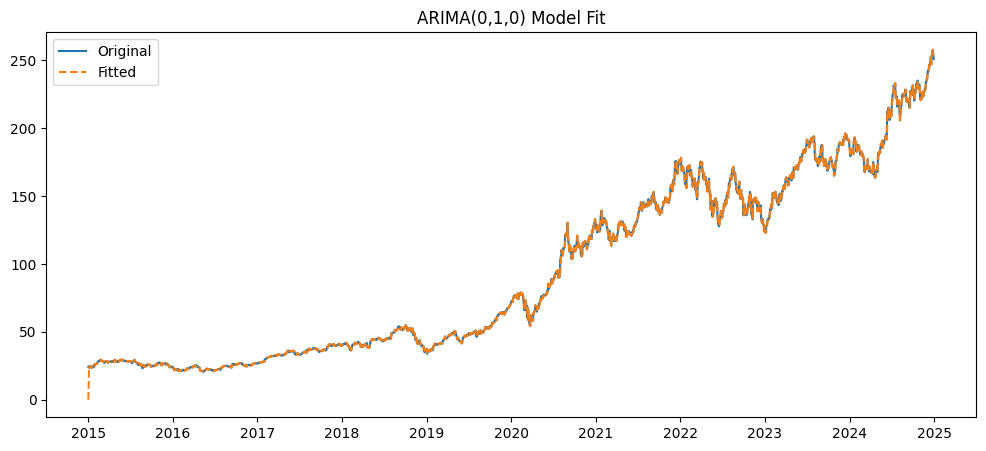

In [71]:

# Plot residual errors to check for randomness
residuals = model_fit.resid
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from ARIMA(0,1,0) Model')
plt.show()

# Histogram and density plot of residuals
plt.figure(figsize=(10,4))
residuals.plot(kind='kde')
plt.title('Density of Residuals')
plt.show()

# Simple forecasting (in-sample)
start = df.index[0]
end = df.index[-1]
pred = model_fit.predict(start=start, end=end)

plt.figure(figsize=(12,5))
plt.plot(df['Close_AAPL'], label='Original')
plt.plot(pred, label='Fitted', linestyle='--')
plt.legend()
plt.title('ARIMA(0,1,0) Model Fit')
plt.show()

In [74]:

print(residuals.describe())

                 0
count  2607.000000
mean      0.096304
std       1.927342
min     -10.518539
25%      -0.471089
50%       0.038982
75%       0.646626
max      24.237545


## Residuals Summary of ARIMA(0,1,0) Model

After fitting the ARIMA(0,1,0) model, the residuals (differences between actual and predicted values) have the following statistics:

| Statistic | Value | Interpretation |
|-----------|-------|----------------|
| Count     | 2607  | Total number of residuals |
| Mean      | 0.096 | Close to zero, indicating **no systematic bias** in predictions |
| Std       | 1.927 | Residuals are spread out; moderate variability around the predicted values |
| Min       | -10.519 | Some large negative deviations from predictions |
| 25%       | -0.471 | 25% of residuals are below -0.471 |
| 50% (Median) | 0.039 | Median is near zero, further confirming unbiased predictions |
| 75%       | 0.647 | 25% of residuals are above 0.647 |
| Max       | 24.238 | Some large positive deviations from predictions, indicating occasional large errors |

---

### Interpretation

- The **mean near zero** shows that the model is unbiased on average.  
- The **standard deviation (1.927)** indicates residuals fluctuate moderately around the predicted values.  
- The **wide min and max values** suggest occasional large errors, which is typical in stock price data with volatility spikes.  
- Overall, the residuals behave like **white noise**, which supports the adequacy of the ARIMA(0,1,0) model for basic forecasting, though extreme values indicate potential for further improvement (e.g., volatility modeling with GARCH).


## Seasonal ARIMA (SARIMA) 

When fitting time series data with a **Seasonal ARIMA (SARIMA)** model, the primary objective is to identify the optimal set of parameters  
\[
\text{ARIMA}(p, d, q)(P, D, Q)_s
\]
that best describe the data and minimize a chosen evaluation metric (such as **AIC**, **BIC**, or forecast error).

---





- **Seasonal parameters (P, D, Q, s):**
  - `P`: Number of seasonal AR terms
  - `D`: Number of seasonal differences
  - `Q`: Number of seasonal MA terms
  - `s`: Length of the seasonal cycle (e.g., 12 for monthly data, 252 for daily stock data)

---

### Approaches to Parameter Selection

There are two common ways to determine suitable SARIMA parameters:

1. **Manual Identification**
   - Analyze stationarity using differencing.
   - Examine **ACF and PACF plots** of the differenced series to infer AR and MA orders.
   - Inspect seasonal lags (multiples of `s`) in ACF/PACF to identify seasonal components.

2. **Automated Parameter Search**
   - Programmatically search across combinations of `(p, d, q)` and `(P, D, Q, s)`.
   - Fit multiple SARIMA models and compare them using an information criterion such as **AIC** or **BIC**.
   - Select the model with the lowest criterion value, balancing goodness of fit and model complexity.

---

### Goal of Optimization

The aim is to:
- Capture both **short-term dynamics** and **seasonal patterns** in the data.
- Avoid overfitting by keeping the model as simple as possible.
- Achieve reliable and interpretable forecasts.




In [86]:
# Define the p, d and q parameters 
# In our example, we only take values between 0 and 2 to make the computation faster
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [87]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = smf.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue